In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

signal = pd.read_csv("signal.csv")
bkgnd = pd.read_csv("background.csv")
test_data = pd.read_csv("Test.csv")

In [3]:
test_data = test_data.drop(['Z_m', 'dimuon_m'], axis=1)

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311198 entries, 0 to 311197
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   dilepton_m          311198 non-null  float64
 1   leading_lepton_pt   311198 non-null  float64
 2   trailing_lepton_pt  311198 non-null  float64
 3   leading_muon_pt     311198 non-null  float64
 4   trailing_muon_pt    311198 non-null  float64
 5   dimuon_pt           311198 non-null  float64
 6   rIsoOverPtl1        311198 non-null  float64
 7   rIsoOverPtl2        311198 non-null  float64
 8   rIsoOverPtm1        311198 non-null  float64
 9   rIsoOverPtm2        311198 non-null  float64
 10  ipSm1               311198 non-null  float64
 11  ipSm2               311198 non-null  float64
dtypes: float64(12)
memory usage: 28.5 MB


In [5]:
signal['signal/bkgnd'] = 1
bkgnd['signal/bkgnd'] = 0

In [6]:
signal = signal.drop(['Z_m', 'dimuon_m'], axis=1)
bkgnd = bkgnd.drop(['Z_m', 'dimuon_m'], axis=1)

In [7]:
df = pd.concat([signal,bkgnd])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143823 entries, 0 to 133080
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   dilepton_m          143823 non-null  float64
 1   leading_lepton_pt   143823 non-null  float64
 2   trailing_lepton_pt  143823 non-null  float64
 3   leading_muon_pt     143823 non-null  float64
 4   trailing_muon_pt    143823 non-null  float64
 5   dimuon_pt           143823 non-null  float64
 6   rIsoOverPtl1        143823 non-null  float64
 7   rIsoOverPtl2        143823 non-null  float64
 8   rIsoOverPtm1        143823 non-null  float64
 9   rIsoOverPtm2        143823 non-null  float64
 10  ipSm1               143823 non-null  float64
 11  ipSm2               143823 non-null  float64
 12  signal/bkgnd        143823 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 15.4 MB


In [8]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus (signal/bkgnd and masses)
train_y = df['signal/bkgnd'] #label = signal/bkgnd

In [9]:
#SIGNAL
signal_x = signal.drop(['signal/bkgnd'], axis=1)
signal_y = signal['signal/bkgnd']

In [10]:
#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

In [11]:
#SAMPLING DATA
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.3, 
                                                  random_state=1)

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.3, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.3, 
                                                  random_state=1)

In [12]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', 
                          max_depth = 3, 
                          learning_rate=0.028 
                          #gamma=10, 
                          #min_child_weight=5
                         )
#fit = training
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.028, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
predict_signal = model.predict(test_signal_x)
print(np.round(accuracy_score(test_signal_y,predict_signal)*100, 2),'%')

86.57 %


In [14]:
predict_prob = model.predict_proba(test_signal_x)
#converting prob values to list
df_prob = pd.DataFrame(predict_prob)
s_prob_signal = df_prob[df_prob.columns[1]] 
list_prob_signal = s_prob_signal.values.tolist()
df_prob.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3223 entries, 0 to 3222
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3223 non-null   float32
 1   1       3223 non-null   float32
dtypes: float32(2)
memory usage: 25.3 KB


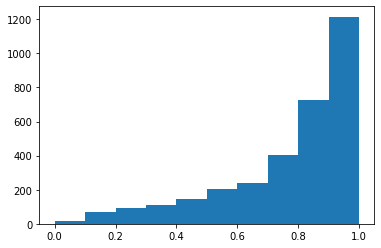

In [15]:
hist_signal = plt.hist(list_prob_signal, range=(0,1))

In [16]:
predict_prob_bkgnd = model.predict_proba(test_bkgnd_x)
df_prob_bkgnd = pd.DataFrame(predict_prob_bkgnd)
s_prob_bkgnd = df_prob_bkgnd[df_prob_bkgnd.columns[1]] 
list_prob_bkgnd = s_prob_bkgnd.values.tolist()

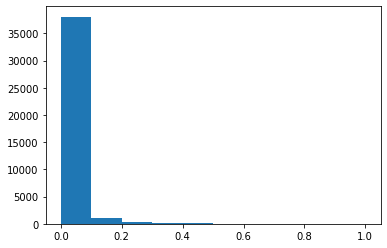

In [17]:
hist_bkgnd = plt.hist(list_prob_bkgnd, range=(0,1))

Text(0.5, 1.0, 'Signal vs Bkgnd (XGB)')

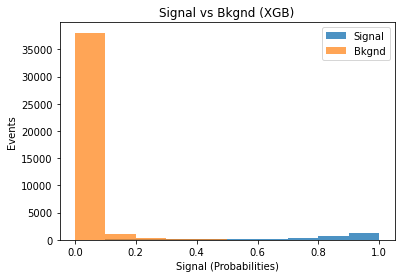

In [18]:
plt.hist(list_prob_signal, range=(0,1), alpha=0.8,label='Signal')
plt.hist(list_prob_bkgnd, range=(0,1), alpha=0.7, label='Bkgnd')
plt.legend(loc='upper right')
plt.xlabel('Signal (Probabilities)')
plt.ylabel('Events')
plt.title('Signal vs Bkgnd (XGB)')

ROC AUC=  0.9971849040010481


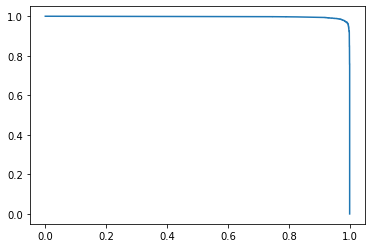

In [19]:
model_predict1 = model.predict_proba(test_x)
model_predict1 = model_predict1[:,1]
auc_score1 = roc_auc_score(test_y, model_predict1)
fpr1, tpr1, _ = roc_curve(test_y, model_predict1)
testp = plt.plot(tpr1, 1-fpr1, label='test')
print('ROC AUC= ', auc_score1)
plt.show()

ROC AUC=  0.9973426763828337


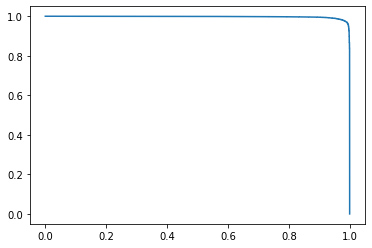

In [20]:
model_predict2 = model.predict_proba(train_x)
model_predict2 = model_predict2[:,1]
auc_score = roc_auc_score(train_y, model_predict2)
fpr2, tpr2, _ = roc_curve(train_y, model_predict2)
trainp = plt.plot(tpr2, 1-fpr2, label='train')
print('ROC AUC= ', auc_score)
plt.show()

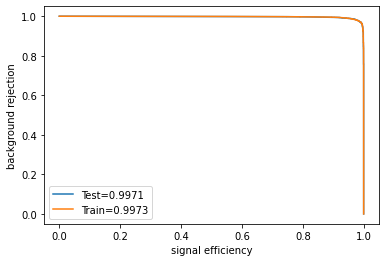

In [21]:
plt.plot(tpr1, 1-fpr1, label='Test=0.9971')
plt.plot(tpr2, 1-fpr2, label='Train=0.9973')
plt.legend(loc='lower left')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.show()

In [22]:
test_prob = model.predict_proba(test_data)
#converting prob values to list
df_test = pd.DataFrame(test_prob)
df_test_signal= df_test[df_test.columns[1]]
list_test_signal = df_test_signal.values.tolist()

In [23]:
signal_val = []
for i in list_test_signal:
    if(i >=0.5):
        signal_val.append(i)
#df_test_50 = df_test[df_test.signal >= 0.5]

In [24]:
len(signal_val)

3063

Text(0, 0.5, 'Events')

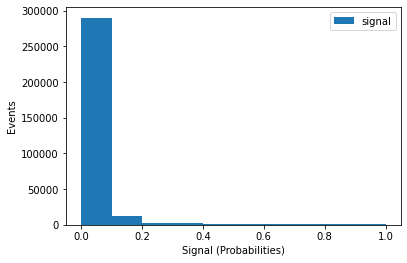

In [25]:
test_hist_signal = plt.hist(list_test_signal, range=(0,1), label='signal')
plt.legend(loc='upper right')
plt.xlabel('Signal (Probabilities)')
plt.ylabel('Events')

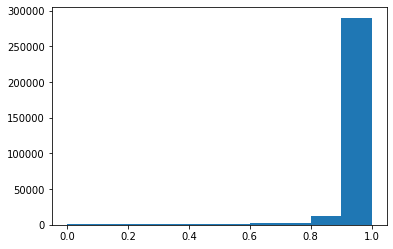

In [26]:
df_test_bkgnd= df_test[df_test.columns[0]]
list_test_bkgnd = df_test_bkgnd.values.tolist()
test_hist_bkgnd = plt.hist(list_test_bkgnd, range=(0,1))

In [27]:
bkgnd_val = []
for j in list_test_bkgnd:
    if(j >=0.5):
        bkgnd_val.append(j)
len(bkgnd_val)

308135

In [28]:
test_data = pd.read_csv("Test.csv")

In [29]:
test_data.head()

,Z_m,dimuon_m,dilepton_m,leading_lepton_pt,trailing_lepton_pt,leading_muon_pt,trailing_muon_pt,dimuon_pt,rIsoOverPtl1,rIsoOverPtl2,rIsoOverPtm1,rIsoOverPtm2,ipSm1,ipSm2
0,102.866327,3.202481,42.465544,11.249890,4.666080,15.860048,6.082700,21.709194,7.497133,13.581632,2.573745,1.173169,9.882916,5.031287
1,123.824175,3.203046,6.945626,11.246214,4.013403,15.853753,6.084754,21.704831,2.300131,13.586072,2.574767,1.172773,9.882916,5.031287
2,100.055824,3.215899,0.461662,11.247336,1.648208,15.871031,6.110661,21.746590,100.873146,13.584717,2.571964,1.167801,9.882916,5.031287
3,100.296534,3.207977,1.119576,11.242681,1.585346,15.857592,6.095163,21.718501,102.542061,13.590342,2.574144,1.170770,9.882916,5.031287
4,98.912342,3.207810,5.467503,11.253211,1.253741,15.861873,6.094266,21.721940,0.732423,13.577624,2.573449,1.170943,9.882916,5.031287


In [30]:
test_data['XGBoost'] = test_prob[:,1]

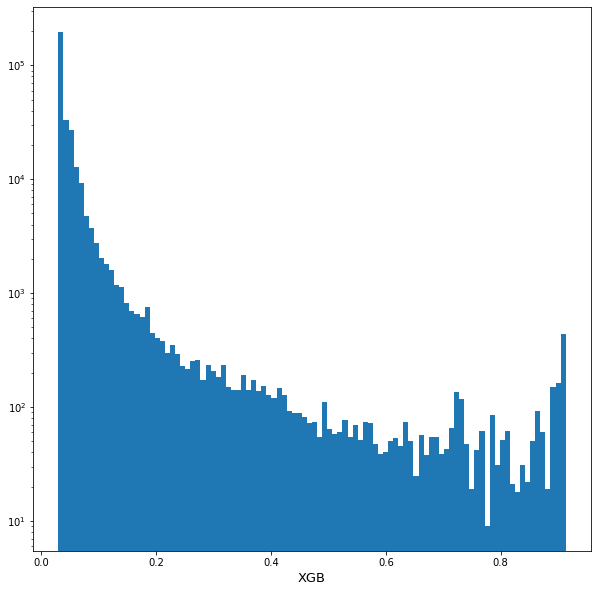

In [31]:
#plot 
plt.figure(figsize=(10,10))
plt.hist(test_data.XGBoost, bins=100)
plt.yscale('log')
plt.xlabel('XGB', fontsize=13)
plt.show()

In [32]:
XGB_50 = test_data[test_data.XGBoost>0.5]
XGB_70 = test_data[test_data.XGBoost>0.7]
XGB_80 = test_data[test_data.XGBoost>0.8]
XGB_85 = test_data[test_data.XGBoost>0.85]
XGB_90 = test_data[test_data.XGBoost>0.9]
XGB_95 = test_data[test_data.XGBoost>0.95]
XGB_96 = test_data[test_data.XGBoost>0.96]
XGB_97 = test_data[test_data.XGBoost>0.97]
XGB_98 = test_data[test_data.XGBoost>0.98]
XGB_99 = test_data[test_data.XGBoost>0.99]

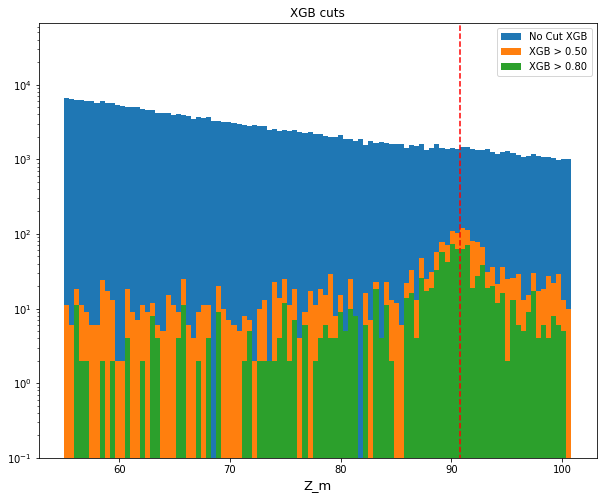

In [33]:
plt.figure(figsize=(10,8))
plt.title('XGB cuts')
m = plt.hist(test_data.Z_m, range=(55,100.86), bins=100, label='No Cut XGB')
plt.hist(XGB_50.Z_m, range=(55,100.86), bins=100, label='XGB > 0.50')
plt.hist(XGB_80.Z_m, range=(55,100.86), bins=100, label='XGB > 0.80')
plt.plot([90.8, 90.8],[0, max(m[0])*13], color='r', ls='--')
plt.yscale('log')
plt.ylim(0.1, max(m[0])*10)
plt.xlabel(r'Z_m', fontsize=13)
plt.legend()
plt.show()

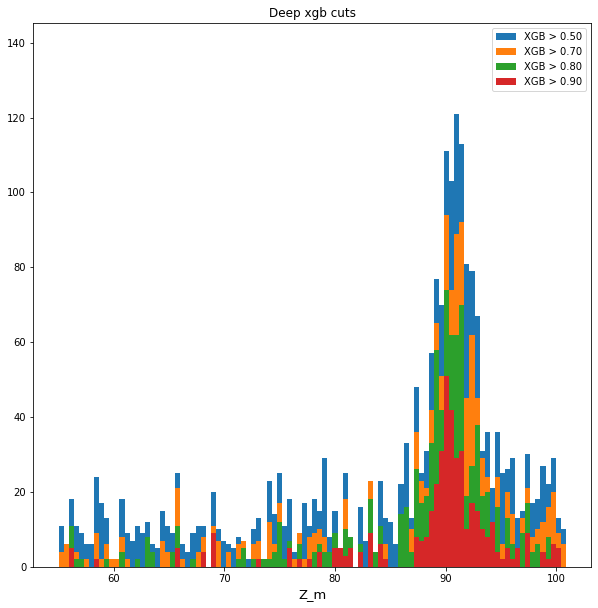

In [34]:
plt.figure(figsize=(10,10))
#m = plt.hist(XGB_50.BMass, range=(4.8,5.8), bins=100)
#plt.hist(XGB_80.BMass, range=(4.8,5.8), bins=100)
plt.title('Deep xgb cuts')
m0 = plt.hist(XGB_50.Z_m, range=(55,100.86), bins=100, label='XGB > 0.50')
plt.hist(XGB_70.Z_m, range=(55,100.86), bins=100, label='XGB > 0.70')
plt.hist(XGB_80.Z_m, range=(55,100.86), bins=100, label='XGB > 0.80')
#plt.hist(XGB_85.Z_m, range=(55,100.86), bins=100, label='XGB > 0.85')
plt.hist(XGB_90.Z_m, range=(55,100.86), bins=100, label='XGB > 0.90')
#m = plt.hist(XGB_96.Z_m, range=(55,100.86), bins=100, label='XGB > 0.96')
#plt.hist(XGB_97.Z_m, range=(55,100.86), bins=100, label='XGB > 0.97')
#plt.hist(XGB_98.Z_m, range=(55,100.86), bins=100, label='XGB > 0.98')
#plt.hist(XGB_99.Z_m, range=(55,100.86), bins=100, label='XGB > 0.99')
#plt.plot([5.279, 5.279],[0, max(m0[0])*1.3], color='r', ls='--')
plt.ylim(0, max(m0[0])*1.2)
plt.xlabel(r'Z_m', fontsize=13)
plt.legend()
plt.show()

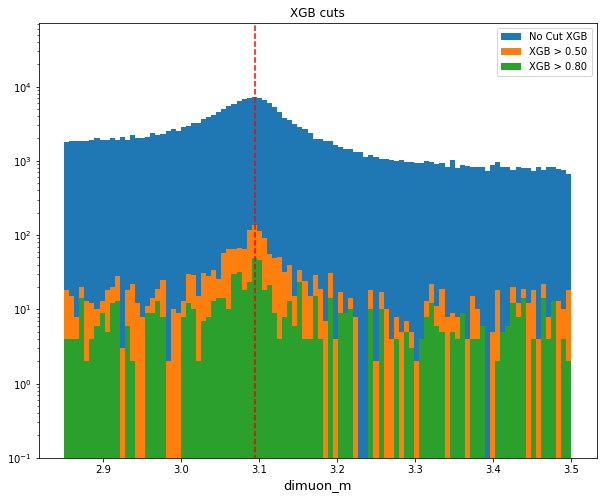

In [39]:
plt.figure(figsize=(10,8))
plt.title('XGB cuts')
m = plt.hist(test_data.dimuon_m, range=(2.85,3.5), bins=100, label='No Cut XGB')
plt.hist(XGB_50.dimuon_m, range=(2.85,3.5), bins=100, label='XGB > 0.50')
plt.hist(XGB_80.dimuon_m, range=(2.85,3.5), bins=100, label='XGB > 0.80')
plt.plot([3.095, 3.095],[0, max(m[0])*13], color='r', ls='--')
plt.yscale('log')
plt.ylim(0.1, max(m[0])*10)
plt.xlabel(r'dimuon_m', fontsize=13)
plt.legend()
plt.show()

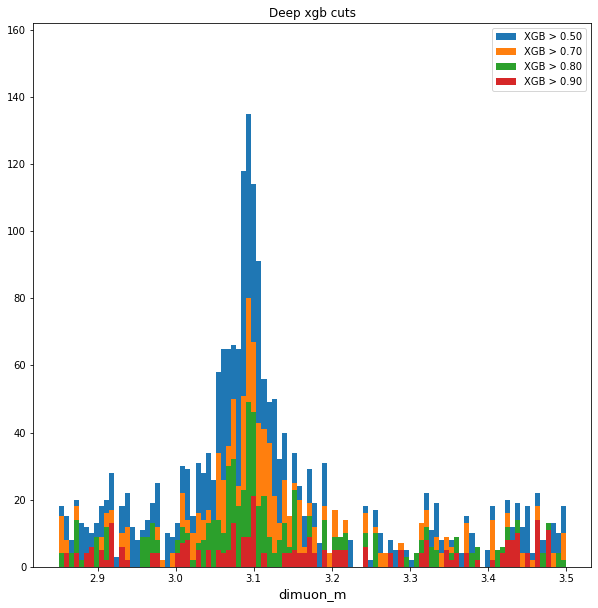

In [41]:
plt.figure(figsize=(10,10))
#m = plt.hist(XGB_50.BMass, range=(4.8,5.8), bins=100)
#plt.hist(XGB_80.BMass, range=(4.8,5.8), bins=100)
plt.title('Deep xgb cuts')
m0 = plt.hist(XGB_50.dimuon_m, range=(2.85,3.5), bins=100, label='XGB > 0.50')
plt.hist(XGB_70.dimuon_m, range=(2.85,3.5), bins=100, label='XGB > 0.70')
plt.hist(XGB_80.dimuon_m, range=(2.85,3.5), bins=100, label='XGB > 0.80')
#plt.hist(XGB_85.Z_m, range=(55,100.86), bins=100, label='XGB > 0.85')
plt.hist(XGB_90.dimuon_m, range=(2.85,3.5), bins=100, label='XGB > 0.90')
#m = plt.hist(XGB_96.Z_m, range=(55,100.86), bins=100, label='XGB > 0.96')
#plt.hist(XGB_97.Z_m, range=(55,100.86), bins=100, label='XGB > 0.97')
#plt.hist(XGB_98.Z_m, range=(55,100.86), bins=100, label='XGB > 0.98')
#plt.hist(XGB_99.Z_m, range=(55,100.86), bins=100, label='XGB > 0.99')
#plt.plot([5.279, 5.279],[0, max(m0[0])*1.3], color='r', ls='--')
plt.ylim(0, max(m0[0])*1.2)
plt.xlabel(r'dimuon_m', fontsize=13)
plt.legend()
plt.show()